# Tests on .idf file manipulations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from eppy.modeleditor import IDF
import seaborn as sns
import html5lib

## Eppy 

### How use eppy to run EnergyPlus

The use of the `eppy` library to run an `EnergyPlus` simulation requires the same input as a conventionnal simulation:
- an `.idf` file containing the description of the building, site, schedules, HVAC, etc ...
- an `.idd` file containing the dictionary that the simulator is going to use to decode the `.idf` file. *This file is version dependent* and one should care to use the right `.idd` based on his `EnergyPlus` distribution.
- an `.epw` file, containing the weather data that will be used during the simulation. This file is mandatory to run the simulation but is optionnal if `eppy` is used to only edit `.idf` files.

In [589]:
## Define the paths to the various inputs
# Specify path to the IDF file

idf_file_path = r".\input_data\CELLS.idf"

# Specify path to the IDD file
idd_file_path = r".\input_data\Energy+.idd" # Energy+ v9.4 IDD

# Specify path to the weather file
weather_file_path = r".\input_data\-_FRIBOURG_MN7.epw"

# Set the idd file
IDF.setiddname(idd_file_path)

# Create an IDF object and load the IDF file
idf = IDF(idf_file_path, weather_file_path)

Once the object is created as a python object, `eppy` provides a lot of method to programmatically access to information about the `.idf` file.

In [572]:
# Print and check the idf file is the correct one 
idf.printidf()


Version,
    9.4.0.002;                !- Version Identifier

SimulationControl,
    Yes,                      !- Do Zone Sizing Calculation
    Yes,                      !- Do System Sizing Calculation
    Yes,                      !- Do Plant Sizing Calculation
    No,                       !- Run Simulation for Sizing Periods
    Yes;                      !- Run Simulation for Weather File Run Periods

Building,
    Building,                 !- Name
    0,                        !- North Axis
    Suburbs,                  !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.4,                      !- Temperature Convergence Tolerance Value
    FullExterior,             !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

ShadowCalculation,
    PolygonClipping,          !- Shading Calculation Method
    Periodic,                 !- Shading Calculation Update

Now that our `.idf` file is loaded as an object, `eppy` provides a compact and handy way to run a simulation with `EnergyPlus`

In [590]:
## Run base simulation
# readvars = True creates a .cvs of the results
# annual = True forces the simulation to run on an annual basis

idf.run(readvars=True,output_directory=r'.\output_data', annual=True, verbose='q', output_prefix='idf1_')

### Retrieve results and visualize them

The easy way to retrieve data is to use the power of Python libraries to manipulate large datasets. `Pandas` is probably the most complete and easy way to handle datasets in this range of size. The direct way is to make sure the results were generated as a `.csv` and simply load it as a `DataFrame` object. Then get back to your good old pandas habits!

**Note:** The timestamps of the `.csv` are not easily read and interpreted as timeseries by `Pandas`. Parsing them _à priori_ helps to correctly read the file. An adapted date parsing function resolves that, as the one proposed by [Steven Firth](https://www.stevenfirth.com/energyplus-simulation-and-analysis-using-python/) on his website. All credits to him.

In [532]:
# Steven Firth datetime parser
def parse_energyplus_datetime_string(st, year=2021):
    st=st.strip()
    month=int(st[0:2])
    day=int(st[3:5])
    hour=int(st[7:9])
    minute=int(st[10:12])
    second=(st[13:15])
    if not hour==24:
        dt=pd.Timestamp(year,month,day,hour,minute)
    else:
        hour=0
        dt=pd.Timestamp(year,month,day,hour,minute)
        dt+=pd.Timedelta('1 day')
    return dt

In [533]:
df=pd.read_csv(r".\output_data\idf1_out.csv", 
               parse_dates=[0],
               index_col=[0],
               date_parser=parse_energyplus_datetime_string 
              )
df.head()

,Environment:Site Outdoor Air Drybulb Temperature [C](Hourly),Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly),Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly),Environment:Site Wind Speed [m/s](Hourly),Environment:Site Wind Direction [deg](Hourly),Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](Hourly),Environment:Site Direct Solar Radiation Rate per Area [W/m2](Hourly),Environment:Site Solar Azimuth Angle [deg](Hourly),Environment:Site Solar Altitude Angle [deg](Hourly),CELLS:ROOMX1:Zone Total Internal Latent Gain Energy [J](Hourly),...,CELLS:ROOMX1:Zone Mechanical Ventilation Standard Density Volume Flow Rate [m3/s](Hourly),CELLS:ROOMX1:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),CELLS:ENTRANCE:Zone Mechanical Ventilation Standard Density Volume Flow Rate [m3/s](Hourly),CELLS:ENTRANCE:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),CELLS:ROOMX2:Zone Mechanical Ventilation Standard Density Volume Flow Rate [m3/s](Hourly),CELLS:ROOMX2:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),Electricity:Facility [J](Hourly),InteriorEquipment:Electricity [J](Hourly),InteriorLights:Electricity [J](Hourly),Carbon Equivalent:Facility [kg](Hourly)
Date/Time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 01:00:00,7.500,5.300,94390.0,0.650,183.75,0.0,0.0,8.485838,-66.010149,0.0,...,0.013549,0.827465,0.014966,1.160685,0.014261,0.827421,538798.420885,5812.315488,0.0,0.0
2021-01-01 02:00:00,7.875,4.400,94328.0,0.500,232.25,0.0,0.0,36.510800,-62.284889,0.0,...,0.013549,0.827749,0.014966,1.160887,0.014261,0.827709,538798.420885,5812.315488,0.0,0.0
2021-01-01 03:00:00,7.750,3.625,94328.0,0.250,249.75,0.0,0.0,58.861858,-54.694178,0.0,...,0.013549,0.827150,0.014966,1.159841,0.014261,0.827111,538798.420885,5812.315488,0.0,0.0
2021-01-01 04:00:00,7.625,3.350,94328.0,0.425,261.00,0.0,0.0,74.726170,-45.281853,0.0,...,0.013549,0.826560,0.014966,1.158873,0.014261,0.826520,538798.420885,5812.315488,0.0,0.0
2021-01-01 05:00:00,7.525,3.150,94328.0,0.500,263.50,0.0,0.0,87.107574,-35.171794,0.0,...,0.013549,0.826022,0.014966,1.158011,0.014261,0.825984,538798.420885,5812.315488,0.0,0.0


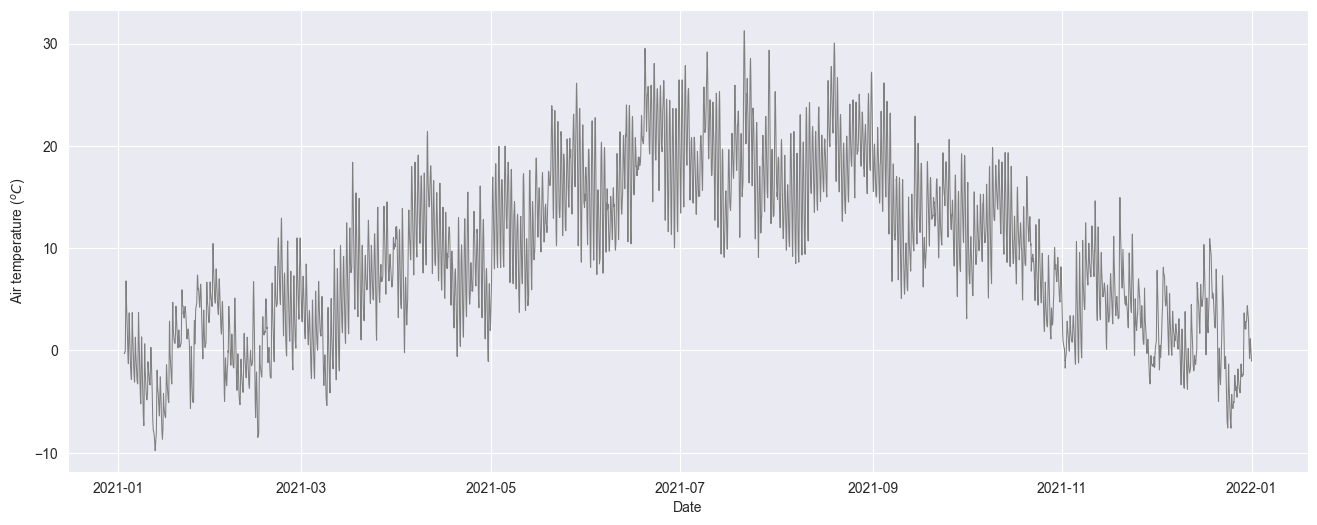

In [534]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df['Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)'][48:],
        color='grey',
        linewidth=0.75
        )
ax.set_xlabel('Date')
ax.set_ylabel('Air temperature (${^o}C$)')
plt.show()

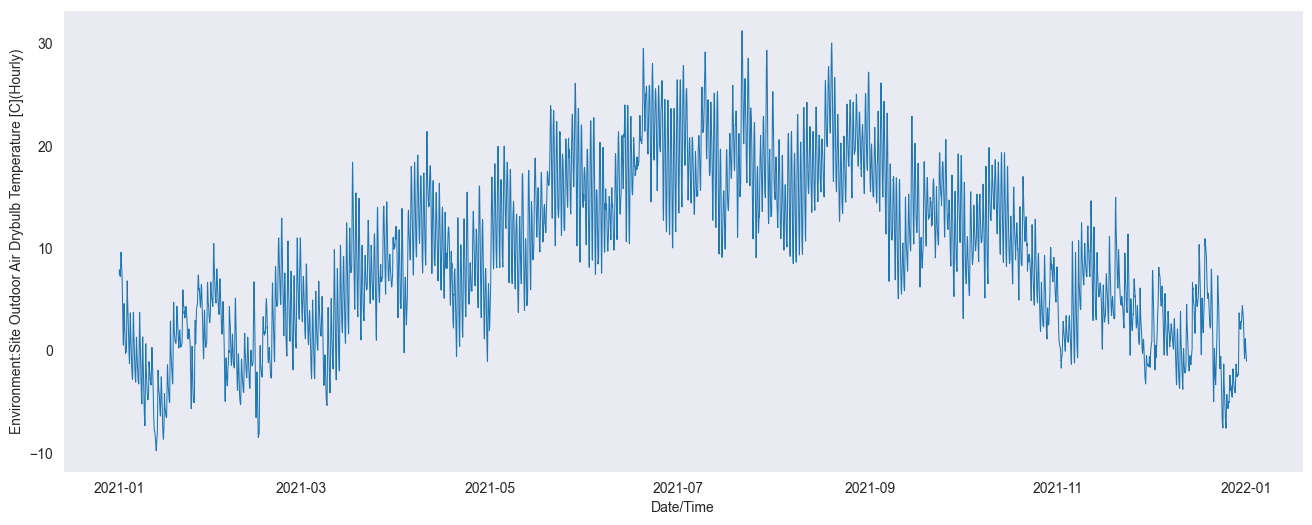

In [535]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(data=df, x='Date/Time', y='Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)', linewidth=0.75)
plt.grid()

### Modify `.idf` files using `eppy`

The first goal of this library is to programmatically access the `.idf` files and modify their content using Python. Let's see how it can be easily done.

In [536]:
idf.printidf()


Version,
    9.4.0.002;                !- Version Identifier

SimulationControl,
    Yes,                      !- Do Zone Sizing Calculation
    Yes,                      !- Do System Sizing Calculation
    Yes,                      !- Do Plant Sizing Calculation
    No,                       !- Run Simulation for Sizing Periods
    Yes;                      !- Run Simulation for Weather File Run Periods

Building,
    Building,                 !- Name
    0,                        !- North Axis
    Suburbs,                  !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.4,                      !- Temperature Convergence Tolerance Value
    FullExterior,             !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

ShadowCalculation,
    PolygonClipping,          !- Shading Calculation Method
    Periodic,                 !- Shading Calculation Update

In the present case, what will be modified is the heating temperature setpoint. To do so, one must first understand how the `.idf` file works and how EnergyPlus manages them. The main structure EnergyPlus needs is a Schedule. A good ressource to understand this structure is [BigLadderSoftware](https://bigladdersoftware.com/epx/docs/9-0/input-output-reference/group-schedules.html). In a nutshell, the structure of the Schedules are divided in 3 subparts:
- Day Schedule (Schedule:Day:Hourly)
- Week Schedule (Schedule:Week:Daily)
- Year Schedule (Schedule:Year)

However, other fields are available to help interface external data with idf files. In this example, the SIA norms are used to define the temperature setpoints. From the `.idf` files, it can be seen that the `Schedule:Day:List` fields is used to define the SIA norms. The index [2] and [3] are respectively defining the heating and cooling setpoints hour by hour. Let's access it with `eppy`.

In [537]:
idf.idfobjects["Schedule:Day:List"][2]



Schedule:Day:List,
    10003_-50_12_21,          !- Name
    Any number,               !- Schedule Type Limits Name
    No,                       !- Interpolate to Timestep
    60,                       !- Minutes per Item
    -50,                      !- Value 1
    -50,                      !- Value 2
    -50,                      !- Value 3
    -50,                      !- Value 4
    -50,                      !- Value 5
    -50,                      !- Value 6
    -50,                      !- Value 7
    12,                       !- Value 8
    21,                       !- Value 9
    21,                       !- Value 10
    21,                       !- Value 11
    21,                       !- Value 12
    12,                       !- Value 13
    21,                       !- Value 14
    21,                       !- Value 15
    21,                       !- Value 16
    21,                       !- Value 17
    12,                       !- Value 18
    -50,                     

In [538]:
# Create a copy of the base idf to modify some values
idf2 = idf.copyidf()

# .copyidf() only copy the idf file part: it is necessary to reassign a weather file
idf2.epw = weather_file_path 

In [539]:
schedule_day_list = idf2.idfobjects["Schedule:Day:List"][2].obj

In [540]:
new_setpoint = 12
for i in range(13, 21):  # Assuming the values start from index 13 and end at index 21
    # Modify the temperature value to 0 degrees Celsius
    schedule_day_list[i] = new_setpoint

In [541]:
idf2.idfobjects["Schedule:Day:List"][2].obj

['Schedule:Day:List',
 '10003_-50_12_21',
 'Any number',
 'No',
 60,
 -50.0,
 -50.0,
 -50.0,
 -50.0,
 -50.0,
 -50.0,
 -50.0,
 12.0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 21.0,
 12.0,
 -50.0,
 -50.0,
 -50.0,
 -50.0,
 -50.0,
 -50.0]

In [542]:
# Run a new simulation with the modified idf
idf2.run(readvars=True,output_directory=r'.\output_data', annual=True, verbose='q', output_prefix='idf2_')

In [543]:
# Load second DataFrame
df2=pd.read_csv(r".\output_data\idf2_out.csv", 
               parse_dates=[0],
               index_col=[0],
               date_parser=parse_energyplus_datetime_string 
              )
df2.head()

,Environment:Site Outdoor Air Drybulb Temperature [C](Hourly),Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly),Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly),Environment:Site Wind Speed [m/s](Hourly),Environment:Site Wind Direction [deg](Hourly),Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](Hourly),Environment:Site Direct Solar Radiation Rate per Area [W/m2](Hourly),Environment:Site Solar Azimuth Angle [deg](Hourly),Environment:Site Solar Altitude Angle [deg](Hourly),CELLS:ROOMX1:Zone Total Internal Latent Gain Energy [J](Hourly),...,CELLS:ROOMX1:Zone Mechanical Ventilation Standard Density Volume Flow Rate [m3/s](Hourly),CELLS:ROOMX1:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),CELLS:ENTRANCE:Zone Mechanical Ventilation Standard Density Volume Flow Rate [m3/s](Hourly),CELLS:ENTRANCE:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),CELLS:ROOMX2:Zone Mechanical Ventilation Standard Density Volume Flow Rate [m3/s](Hourly),CELLS:ROOMX2:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),Electricity:Facility [J](Hourly),InteriorEquipment:Electricity [J](Hourly),InteriorLights:Electricity [J](Hourly),Carbon Equivalent:Facility [kg](Hourly)
Date/Time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 01:00:00,7.500,5.300,94390.0,0.650,183.75,0.0,0.0,8.485838,-66.010149,0.0,...,0.013549,0.822996,0.014966,1.158037,0.014261,0.822935,538798.420885,5812.315488,0.0,0.0
2021-01-01 02:00:00,7.875,4.400,94328.0,0.500,232.25,0.0,0.0,36.510800,-62.284889,0.0,...,0.013549,0.823361,0.014966,1.158184,0.014261,0.823304,538798.420885,5812.315488,0.0,0.0
2021-01-01 03:00:00,7.750,3.625,94328.0,0.250,249.75,0.0,0.0,58.861858,-54.694178,0.0,...,0.013549,0.822834,0.014966,1.157096,0.014261,0.822777,538798.420885,5812.315488,0.0,0.0
2021-01-01 04:00:00,7.625,3.350,94328.0,0.425,261.00,0.0,0.0,74.726170,-45.281853,0.0,...,0.013549,0.822307,0.014966,1.156092,0.014261,0.822250,538798.420885,5812.315488,0.0,0.0
2021-01-01 05:00:00,7.525,3.150,94328.0,0.500,263.50,0.0,0.0,87.107574,-35.171794,0.0,...,0.013549,0.821831,0.014966,1.155200,0.014261,0.821775,538798.420885,5812.315488,0.0,0.0


### Access and plot other results

In [544]:
print(df.columns)
print(f'There is {len(df.columns)} columns in the output file')

Index(['Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)',
       'Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly)',
       'Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly)',
       'Environment:Site Wind Speed [m/s](Hourly)',
       'Environment:Site Wind Direction [deg](Hourly)',
       'Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](Hourly)',
       'Environment:Site Direct Solar Radiation Rate per Area [W/m2](Hourly)',
       'Environment:Site Solar Azimuth Angle [deg](Hourly)',
       'Environment:Site Solar Altitude Angle [deg](Hourly)',
       'CELLS:ROOMX1:Zone Total Internal Latent Gain Energy [J](Hourly)',
       ...
       'CELLS:ROOMX1:Zone Mechanical Ventilation Standard Density Volume Flow Rate [m3/s](Hourly)',
       'CELLS:ROOMX1:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly)',
       'CELLS:ENTRANCE:Zone Mechanical Ventilation Standard Density Volume Flow Rate [m3/s](Hourly)',
       'CELLS:ENTRANCE

In [545]:
print(f'Total facility electricity (annual) : {df['Electricity:Facility [J](Hourly)'].sum()*2.77778e-10:.2} [MW].')

Total facility electricity (annual) : 2.9 [MW].


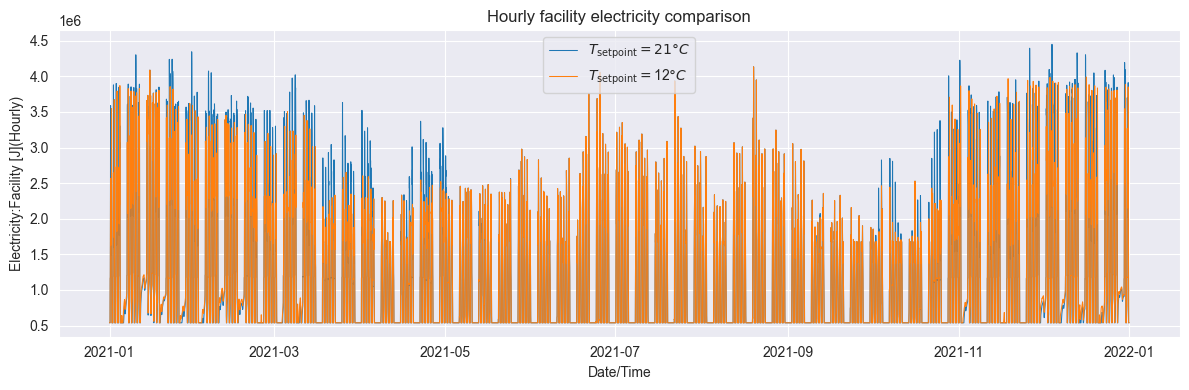

In [546]:
fig = plt.figure(figsize=(12, 4))  # 2 rows, 1 column

sns.lineplot(data=df, x='Date/Time',y='Electricity:Facility [J](Hourly)', linewidth=0.75, label = r'$T_\text{setpoint}= 21\degree C$')
sns.lineplot(data=df2, x='Date/Time',y='Electricity:Facility [J](Hourly)', linewidth=0.75, label= r'$T_\text{setpoint}=$'+ f'{new_setpoint}' + r'$\degree C$')

plt.title('Hourly facility electricity comparison')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

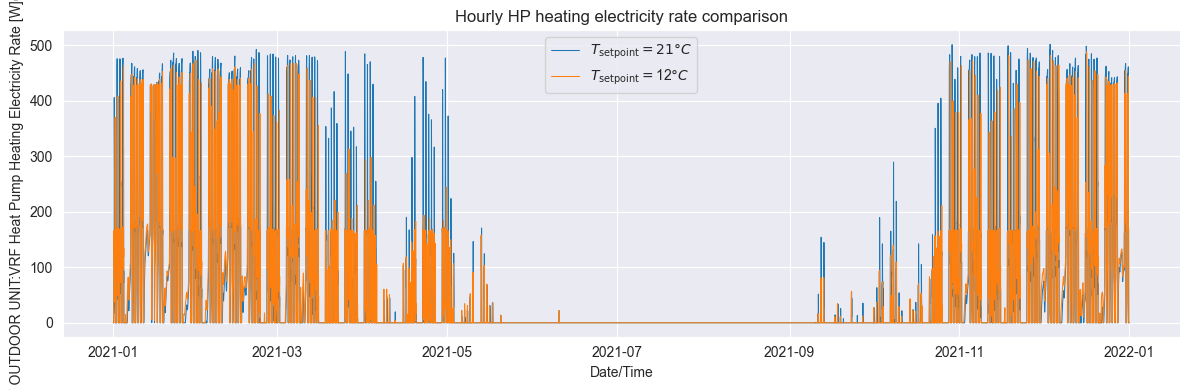

In [547]:
fig = plt.figure(figsize=(12, 4))  # 2 rows, 1 column

sns.lineplot(data=df, x='Date/Time',y='VRF OUTDOOR UNIT:VRF Heat Pump Heating Electricity Rate [W](Hourly)', linewidth=0.75, label = r'$T_\text{setpoint}= 21\degree C$')
sns.lineplot(data=df2, x='Date/Time',y='VRF OUTDOOR UNIT:VRF Heat Pump Heating Electricity Rate [W](Hourly)',linewidth=0.75, label= r'$T_\text{setpoint}=$'+ f'{new_setpoint}' + r'$\degree C$')

plt.title('Hourly HP heating electricity rate comparison')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## REHO in Jupyter

### Setup examples

The next step is to try and play a bit around with `REHO`. The library is mainly built to work with python scripts, but it should be flexible enough to work in a notebook too. This will allow a bit more of flexibility for testing and visualizing how everything interfaces.

In [548]:
from reho.model.reho import *

# Set building parameters
# you can as well define your district from a csv file instead of reading the database
reader = QBuildingsReader()

qbuildings_data = reader.read_csv(buildings_filename=r'..\scripts\template\data\buildings.csv', nb_buildings=2)


# Select weather data
cluster = {'Location': 'Geneva', 'Attributes': ['I', 'T', 'W'], 'Periods': 10, 'PeriodDuration': 24}

# Set scenario
scenario = dict()
scenario['Objective'] = 'TOTEX'
scenario['name'] = 'totex'
scenario['exclude_units'] = ['Battery', 'NG_Cogeneration']
scenario['enforce_units'] = []

# Initialize available units and grids
grids = infrastructure.initialize_grids()
units = infrastructure.initialize_units(scenario, grids)

# Set method options
method = {}

# Run optimization
reho = reho(qbuildings_data=qbuildings_data, units=units, grids=grids, cluster=cluster, scenario=scenario, method=method)

reho.single_optimization()


C:\Users\jamil\Documents\GitHub\REHO\reho\model\preprocessing\QBuildings.py:426: UserWarning:

Geometry column does not contain geometry.



HiGHS 1.6.0: HiGHS 1.6.0: optimal solution; objective 14406.98703
34730 simplex iterations
7 branching nodes
absmipgap=2.33208e-05, relmipgap=1.61871e-09

"option abs_boundtol 1.734723475976807e-18;"
or "option rel_boundtol 1.1427146706831346e-16;"
will change deduced dual values.
              Costs_op     Costs_inv  ANN_factor  Costs_grid_connection  \
Hub                                                                       
Building1  4628.216271  10737.708861    0.061157                    0.0   
Building2 -4601.027391   3964.164618    0.061157                    0.0   
Network    -294.912111  14701.873478    0.061157                    0.0   

           Costs_rep  Costs_ft       GWP_op   GWP_constr  EMOO_CAPEX  \
Hub                                                                    
Building1        0.0       0.0  -892.868048  3897.024730         NaN   
Building2        0.0       0.0 -2473.641627  1652.426075         NaN   
Network          0.0       0.0 -3366.509676  5549.4508

It seems like using the raw examples in a cell works. However, extra care has to be taken to avoid problem when running cells multiple times. Since objects are not cleared at the end of the optimization, conflict when redefining a reho object later might arise. Let's test the plotting methods.

In [549]:
from reho.plotting import plotting

# Performance plot : costs and gwp
plotting.plot_performance(reho.results, plot='costs', indexed_on='Pareto_ID', label='EN_long').show()
plotting.plot_performance(reho.results, plot='gwp', indexed_on='Pareto_ID', label='EN_long').show()

In [550]:
# Create a copy of the base idf to modify some values
idf3 = idf.copyidf()

# .copyidf() only copy the idf file part: it is necessary to reassign a weather file
idf3.epw = weather_file_path 

In [551]:
new_value = 100

for room in idf3.idfobjects['Sizing:System']:
    for key in room.obj:
        print(key)
        #if 'Cooling design capacity (W)' in key:
        

Sizing:System
Air Loop
VentilationRequirement
autosize
1.0
5.0
0.008
11.0
0.008
18.0
18.0
Noncoincident
Yes
Yes
0.008
0.008
Designday




Designday





ZoneSum
1.0
CoolingDesignCapacity
autosize


HeatingDesignCapacity
autosize


VAV


In [552]:
idf3.run(readvars=True, output_directory=r'.\output_data', annual=True, verbose='q', output_prefix='idf3_')
# Load second DataFrame
df3 = pd.read_csv(r".\output_data\idf3_out.csv",
                  parse_dates=[0],
                  index_col=[0],
                  date_parser=parse_energyplus_datetime_string
                  )

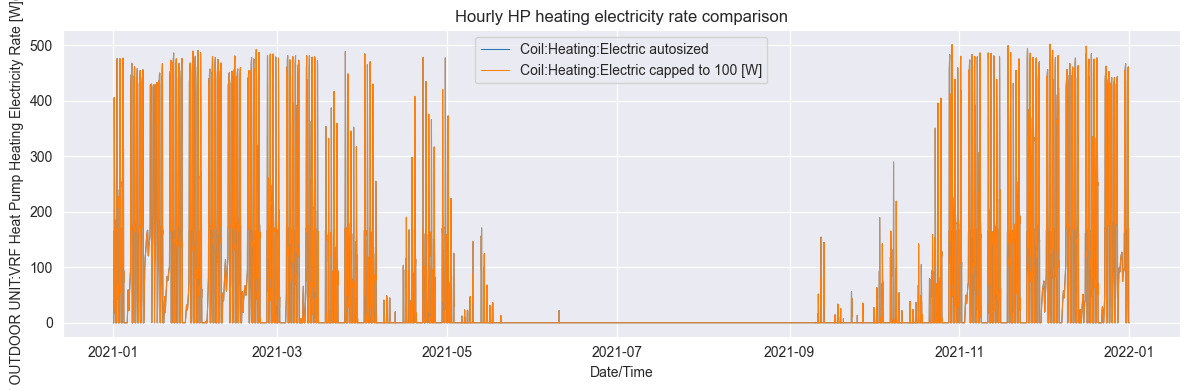

In [553]:
fig = plt.figure(figsize=(12, 4))  # 2 rows, 1 column

sns.lineplot(data=df, x='Date/Time',y='VRF OUTDOOR UNIT:VRF Heat Pump Heating Electricity Rate [W](Hourly)', linewidth=0.75, label = r'Coil:Heating:Electric autosized')
sns.lineplot(data=df3, x='Date/Time',y='VRF OUTDOOR UNIT:VRF Heat Pump Heating Electricity Rate [W](Hourly)',linewidth=0.75, label= f'Coil:Heating:Electric capped to {new_value} [W]')

plt.title('Hourly HP heating electricity rate comparison')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

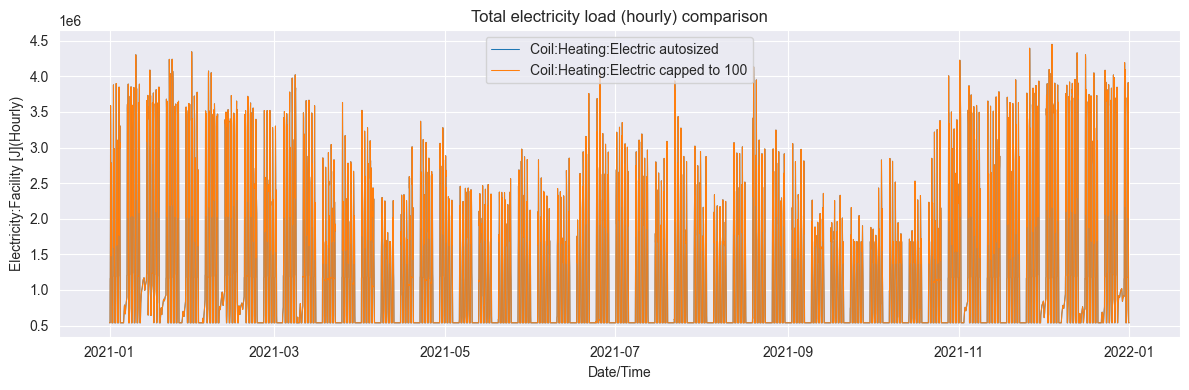

In [554]:
fig = plt.figure(figsize=(12, 4))  # 2 rows, 1 column

sns.lineplot(data=df, x='Date/Time',y='Electricity:Facility [J](Hourly)', linewidth=0.75, label = r'Coil:Heating:Electric autosized')
sns.lineplot(data=df3, x='Date/Time',y='Electricity:Facility [J](Hourly)', linewidth=0.75, label= f'Coil:Heating:Electric capped to {new_value}')

plt.title('Total electricity load (hourly) comparison')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [555]:
# Create a copy of the base idf to modify some values
idf4 = idf.copyidf()

# .copyidf() only copy the idf file part: it is necessary to reassign a weather file
idf4.epw = weather_file_path 

In [556]:
new_value = 100000

for room in idf4.idfobjects['Coil:Heating:Electric']:
    for key in room.objls:
        if key == 'Nominal_Capacity':
            room[key] = new_value

In [557]:
idf4.run(readvars=True, output_directory=r'.\output_data', annual=True, verbose='q', output_prefix='idf4_')
# Load second DataFrame
df4 = pd.read_csv(r".\output_data\idf4_out.csv",
                  parse_dates=[0],
                  index_col=[0],
                  date_parser=parse_energyplus_datetime_string
                  )

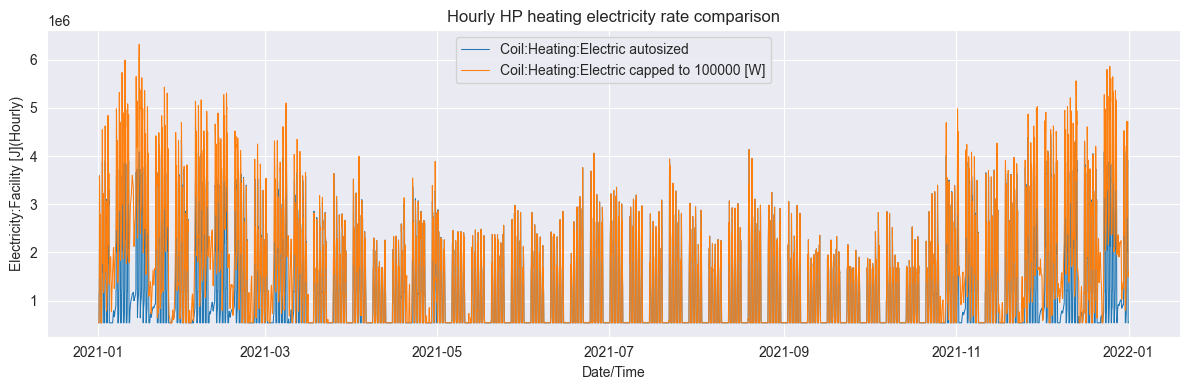

In [558]:
fig = plt.figure(figsize=(12, 4))  # 2 rows, 1 column

sns.lineplot(data=df, x='Date/Time',y='Electricity:Facility [J](Hourly)', linewidth=0.75, label = r'Coil:Heating:Electric autosized')
sns.lineplot(data=df4, x='Date/Time',y='Electricity:Facility [J](Hourly)',linewidth=0.75, label= f'Coil:Heating:Electric capped to {new_value} [W]')

plt.title('Hourly HP heating electricity rate comparison')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Let's try to take advantage of the known structure of the `.idf` file. In this case, for the CELLS project, we know that we're using a modified schedule for heating setpoints. If we already know the specific names of the modified schedules, we can try to retrieve them in our file. The SIA file used for "Individual Office" is named "10003".

In [559]:
def modify_setpoint(idf, new_setpoint=20, modified_hours=list(range(9, 18)), file_SIA='10003_', verbose = 'q'):
    for entity  in idf.idfobjects:
        for field in idf.idfobjects[entity]:
            if 'Name' in field.objls: # check field with names only
                if file_SIA in field.Name: #modify fields where modified SIA file appears
                    for hours in modified_hours:
                        #if hours in modified_hours:
                        # Replace the value with new setpoint
                            setattr(field, f"Value_{hours}", new_setpoint)
                    if verbose != 'q':
                        print(field)

In [560]:
# Create a copy of the base idf to modify some values
idf5 = idf.copyidf()

# .copyidf() only copy the idf file part: it is necessary to reassign a weather file
idf5.epw = weather_file_path 

# Modify temperature setpoint

SIA_heating_schedule = '10003_-50_12_21'
SIA_cooling_schedule = '10003_100_28_26'

new_heating_setpoint = 15
new_cooling_setpoint = 30

modify_setpoint(idf5, new_setpoint= new_heating_setpoint, file_SIA=SIA_heating_schedule)
#modify_setpoint(idf5, new_setpoint= new_cooling_setpoint, file_SIA=SIA_cooling_schedule)


In [561]:
idf5.run(readvars=True, output_directory=r'.\output_data', annual=True, verbose='q', output_prefix='idf5_')
# Load second DataFrame
df5 = pd.read_csv(r".\output_data\idf5_out.csv",
                  parse_dates=[0],
                  index_col=[0],
                  date_parser=parse_energyplus_datetime_string
                  )

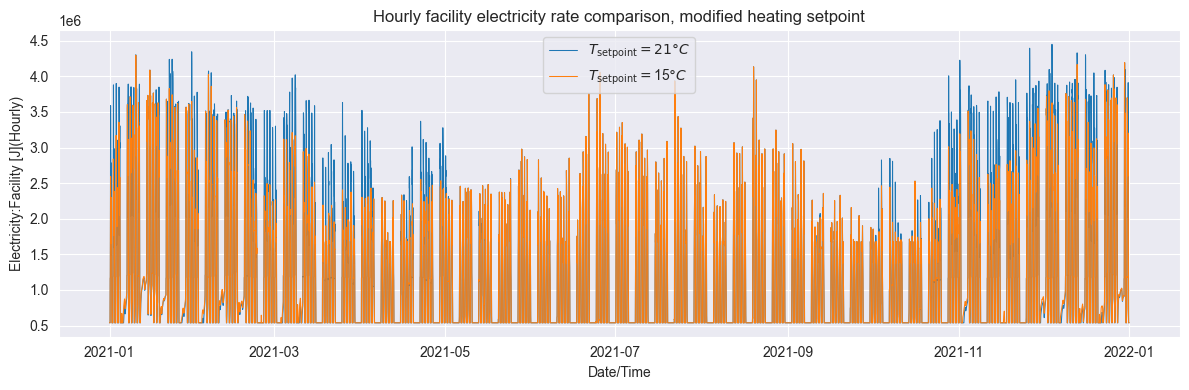

In [562]:
fig = plt.figure(figsize=(12, 4))  # 2 rows, 1 column

sns.lineplot(data=df, x='Date/Time',y='Electricity:Facility [J](Hourly)', linewidth=0.75, label = r'$T_\text{setpoint}=21 \degree C$')
sns.lineplot(data=df5, x='Date/Time',y='Electricity:Facility [J](Hourly)',linewidth=0.75, label= r'$T_\text{setpoint}=$'+ f'{new_heating_setpoint}' + r'$\degree C$')

plt.title('Hourly facility electricity rate comparison, modified heating setpoint')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Now, let's try to limit the capacity of the HVAC equipment through the `idf` file. 

In [567]:
# Create a copy of the base idf to modify some values
idf6 = idf.copyidf()

# .copyidf() only copy the idf file part: it is necessary to reassign a weather file
idf6.epw = weather_file_path 

In [71]:
df_test = pd.read_html(r'output_data\idf1_tbl.htm', header=0)

In [85]:
indices = []
for idx, df in enumerate(df_test):
    # Check if "U-factor" appears in the column names
    if any(isinstance(col, str) and 'U-Factor' in col for col in df.columns):
        # If found, print the table index
        print(idx)
        indices.append(idx)


33
34
35
36
37


In [97]:
df_ufactor = pd.DataFrame(df_test[33])

In [96]:
df_ufactor.columns

Index(['Unnamed: 0', 'Construction', 'Glass Area [m2]', 'Frame Area [m2]',
       'Divider Area [m2]', 'Area of One Opening [m2]',
       'Area of Multiplied Openings [m2]', 'Glass U-Factor [W/m2-K]',
       'Glass SHGC', 'Glass Visible Transmittance',
       'Frame Conductance [W/m2-K]', 'Divider Conductance [W/m2-K]',
       'Shade Control', 'Parent Surface', 'Azimuth [deg]', 'Tilt [deg]',
       'Cardinal Direction'],
      dtype='object')

In [99]:
U_factor = (df_ufactor['U-Factor with Film [W/m2-K]']*df_ufactor['Gross Area [m2]'])/(df_ufactor['Gross Area [m2]'].sum())
U_factor

0    0.169
1    0.169
2    0.169
3    0.169
dtype: float64